In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_dir = "/kaggle/input/plantvillage-dataset/color"  # Parent folder
output_base_dir = "/kaggle/working/split_dataset"

if not os.path.exists(dataset_dir):
    raise ValueError(f"Dataset directory '{dataset_dir}' not found! Check the path.")

class_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

for split in ["train", "val", "test"]:
    for class_name in class_folders:
        os.makedirs(os.path.join(output_base_dir, split, class_name), exist_ok=True)

for class_name in class_folders:
    class_path = os.path.join(dataset_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg'))]
    if len(image_files) == 0:
        print(f"Warning: No images found in {class_name}, skipping...")
        continue
    train_files, test_val_files = train_test_split(image_files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(test_val_files, test_size=0.5, random_state=42)
    def copy_files(file_list, source_dir, target_dir):
        for file in file_list:
            shutil.copy(os.path.join(source_dir, file), os.path.join(target_dir, file))
    copy_files(train_files, class_path, os.path.join(output_base_dir, "train", class_name))
    copy_files(val_files, class_path, os.path.join(output_base_dir, "val", class_name))
    copy_files(test_files, class_path, os.path.join(output_base_dir, "test", class_name))

#  summary
print("Dataset split completed!")
print(f"Train, Validation, and Test sets are saved in: {output_base_dir}")


Dataset split completed!
Train, Validation, and Test sets are saved in: /kaggle/working/split_dataset


In [2]:
import torch
import torch.nn as nn

class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [3]:
import torch.nn.functional as F

def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)  # out_dim: 128 x 128 x 128 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True)  # out_dim: 256 x 64 x 64
        self.conv4 = ConvBlock(256, 512, pool=True)  # out_dim: 512 x 32 x 32
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
         self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                         nn.Flatten(),
                                         nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out)
        out = F.interpolate(out, scale_factor=2, mode='nearest') 
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)
        out = F.interpolate(out, scale_factor=2, mode='nearest') 
        out = self.classifier(out)
        return out


In [4]:
model = ResNet9(3,38) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [5]:
from torchsummary import summary

INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), INPUT_SHAPE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14        [-1, 256, 1

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root="/kaggle/working/split_dataset/train", transform=transform)
val_dataset = datasets.ImageFolder(root="/kaggle/working/split_dataset/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet9(3,num_classes=38).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        val_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] -> Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

In [10]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch [1/10] -> Train Loss: 0.9037, Train Acc: 73.22%, Val Loss: 0.8632, Val Acc: 73.80%
Epoch [2/10] -> Train Loss: 0.2631, Train Acc: 91.47%, Val Loss: 0.4237, Val Acc: 86.31%
Epoch [3/10] -> Train Loss: 0.1650, Train Acc: 94.66%, Val Loss: 0.3221, Val Acc: 89.81%
Epoch [4/10] -> Train Loss: 0.1245, Train Acc: 95.92%, Val Loss: 0.3405, Val Acc: 90.05%
Epoch [5/10] -> Train Loss: 0.0972, Train Acc: 96.74%, Val Loss: 0.1171, Val Acc: 95.89%
Epoch [6/10] -> Train Loss: 0.0821, Train Acc: 97.24%, Val Loss: 0.0790, Val Acc: 97.33%
Epoch [7/10] -> Train Loss: 0.0641, Train Acc: 97.86%, Val Loss: 0.1178, Val Acc: 96.43%
Epoch [8/10] -> Train Loss: 0.0629, Train Acc: 98.03%, Val Loss: 0.3204, Val Acc: 91.29%
Epoch [9/10] -> Train Loss: 0.0545, Train Acc: 98.21%, Val Loss: 0.1371, Val Acc: 96.22%
Epoch [10/10] -> Train Loss: 0.0530, Train Acc: 98.46%, Val Loss: 0.0647, Val Acc: 97.90%


In [11]:
torch.save(model, "/kaggle/working/resnet9_model.pth")

In [12]:
test_dir = "/kaggle/working/split_dataset/test"

y_true = []
y_pred = []
class_names = sorted(os.listdir(test_dir))  # Get class names from folder names
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

In [13]:
import os
import torch
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

y_true = []
y_pred = []

for class_name in class_names:
    class_folder = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_folder):
        continue

    for image_file in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_file)
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            predicted_class = torch.argmax(output, dim=1).item()
        y_true.append(class_to_idx[class_name])
        y_pred.append(predicted_class)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.9824
F1 Score: 0.9824
Precision: 0.9835
Recall: 0.9824


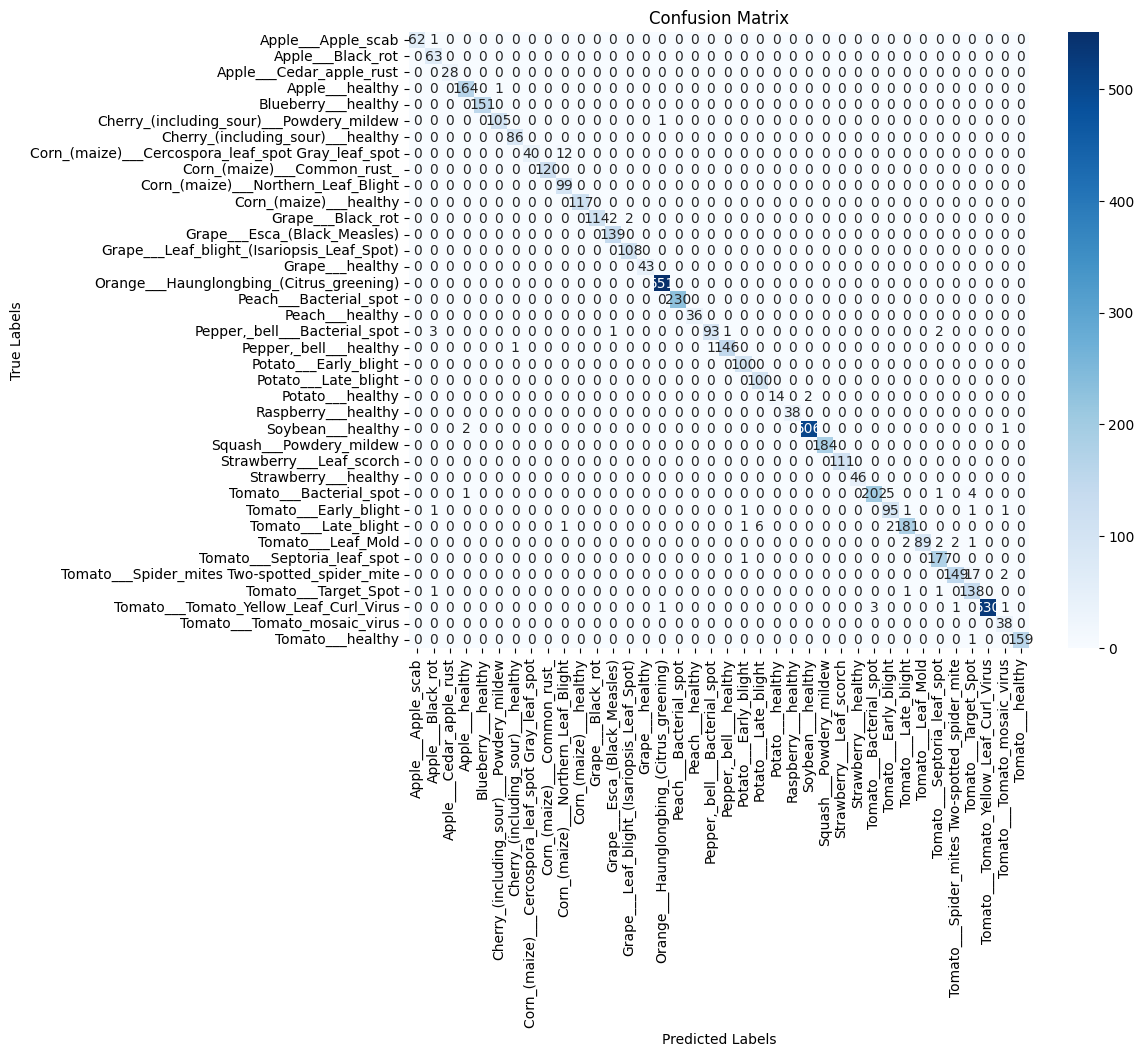

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
